In [2]:
import pandas as pd
import numpy as np

from scipy import signal

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gw_df = pd.read_csv('../data/gw-raw-data/richers_1764.csv')

# y-axis processing
# distance = 3.086e22
# gw_df = gw_df / distance

In [4]:
parameters_df = pd.read_csv('../data/gw-raw-data/richers_1764_parameters.csv')

# limit to only 3 most important parameters
parameters_selected_df = parameters_df[['beta1_IC_b', 'A(km)', 'omega_0(rad|s)', 'Ye_c_b', 'EOS']]
parameters_selected_df.rename(columns={'omega_0(rad|s)': 'omega_0'}, inplace=True)
parameters_selected_df.rename(columns={'A(km)': 'A'}, inplace=True)

/var/folders/qy/p5knypnd54x1dfyxqbs0175r0000gn/T/ipykernel_72874/1526164984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters_selected_df.rename(columns={'omega_0(rad|s)': 'omega_0'}, inplace=True)
/var/folders/qy/p5knypnd54x1dfyxqbs0175r0000gn/T/ipykernel_72874/1526164984.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters_selected_df.rename(columns={'A(km)': 'A'}, inplace=True)


### Parameter Analysis

#### beta1_IC_b: ratio of rotational kinetic to gravitational potential energy of the inner core at bounce

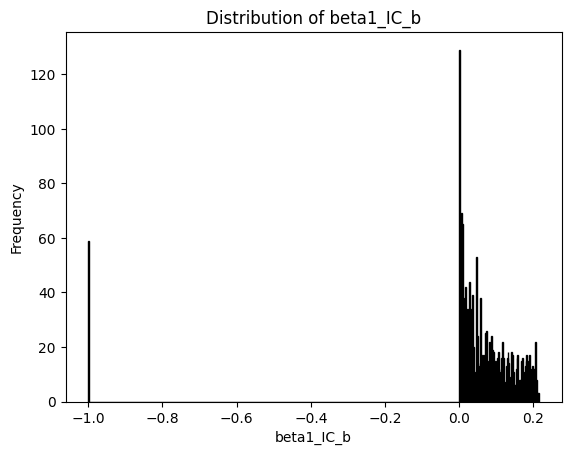

In [5]:
plt.hist(parameters_selected_df['beta1_IC_b'], bins=500, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('beta1_IC_b')
plt.ylabel('Frequency')
plt.title('Distribution of beta1_IC_b')
plt.show()

Where does the -1.0 come from?

In [6]:
parameters_df[parameters_df['beta1_IC_b'] < 0]

,A(km),D*bounce_amplitude_1(cm),D*bounce_amplitude_2(cm),EOS,MbarICgrav(Msun),Mgrav1_IC_b(Msun),Mrest_IC_b(Msun),SNR(aLIGOfrom10kpc),T_c_b(MeV),Ye_c_b,...,omega_max(rad|s),rPNSequator_b(km),rPNSpole_b(km),r_omega_max(km),rho_c_b(g|ccm),rhobar_c_postbounce(g|ccm),s_c_b(kB|baryon),t_bounce_end(s),t_postbounce_end(s),tbounce(s)
151,10000,-1.0,-1.0,SFHo,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
227,10000,-1.0,-1.0,BHBL,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
325,10000,-1.0,-1.0,BHBLP,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
402,1268,-1.0,-1.0,LS180,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
412,10000,-1.0,-1.0,LS180,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
413,10000,-1.0,-1.0,LS180,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
487,634,-1.0,-1.0,LS220,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
500,1268,-1.0,-1.0,LS220,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
510,10000,-1.0,-1.0,LS220,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
511,10000,-1.0,-1.0,LS220,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Seems like signals with beta1_IC_b == -1.0 correspond to erroneous generated signals. Remove from the dataset. Appears that these signals are not correlated to a particular EOS.

Let's inspect the signals with erroneous parameter values

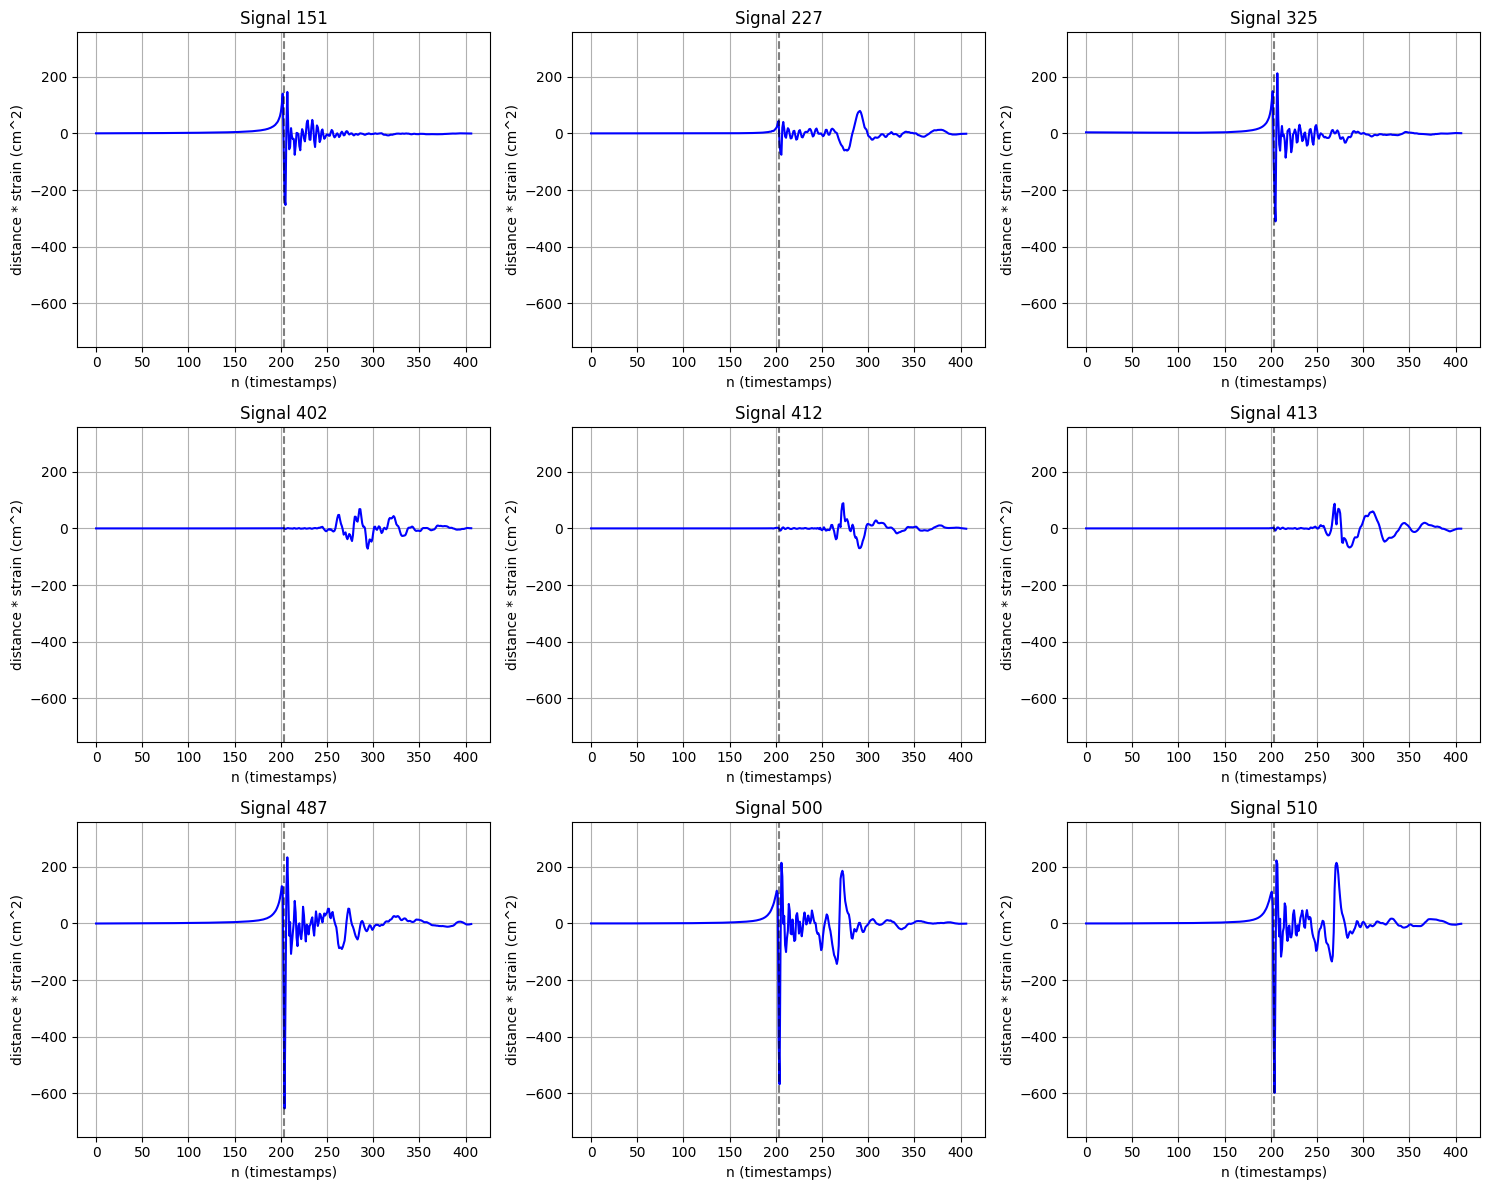

In [8]:
erroneous_indexes = parameters_df[parameters_df['beta1_IC_b'] < 0].index
selected_signals = gw_df.iloc[:, erroneous_indexes] 
# # select 16 random signals
# random_index = np.random.randint(0, gw_df.shape[1], 9)
# selected_signals = gw_df.iloc[:, random_index]  # Assuming the first 64 columns are the signals

num_rows = 3
num_cols = 3

# Determine the common limits for all subplots
common_ylim = (selected_signals.min().min() - 100, selected_signals.max().max() + 100)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(len(selected_signals))
    y = selected_signals.iloc[:, i]
    ax.plot(x, y, color='blue')

    ax.axvline(x=203, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {erroneous_indexes[i]}')
    ax.grid(True)
    ax.set_ylim(common_ylim)
    
    # Add axis titles
    ax.set_ylabel('distance * strain (cm^2)')
    ax.set_xlabel('n (timestamps)')

for i in range(len(selected_signals), num_rows*num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../plots/gw_signals_sample_16_erroneous_signals.png')
plt.show()

Signals appear otherwise 'normal'. Not sure whether it's similar to the original distribution of signals. Maybe can do some kind of statistical analysis?

In [ ]:
parameters_selected_df = parameters_selected_df[parameters_selected_df['beta1_IC_b'] > 0]

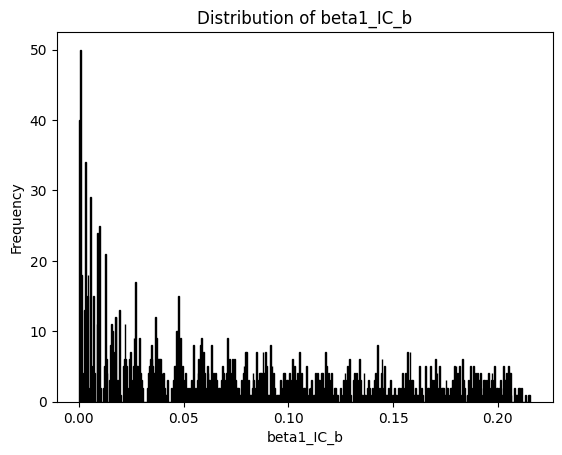

In [ ]:
plt.hist(parameters_selected_df['beta1_IC_b'], bins=500, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('beta1_IC_b')
plt.ylabel('Frequency')
plt.title('Distribution of beta1_IC_b')
# plt.yscale("log")
plt.show()

Split beta_IC_b into 10 equal-frequency bins.

In [ ]:
parameters_selected_df['beta1_IC_b_bins'] = pd.qcut(parameters_selected_df['beta1_IC_b'], q=10, labels=False)

Text(0.5, 1.0, 'Distribution of beta1_IC_b_bins')

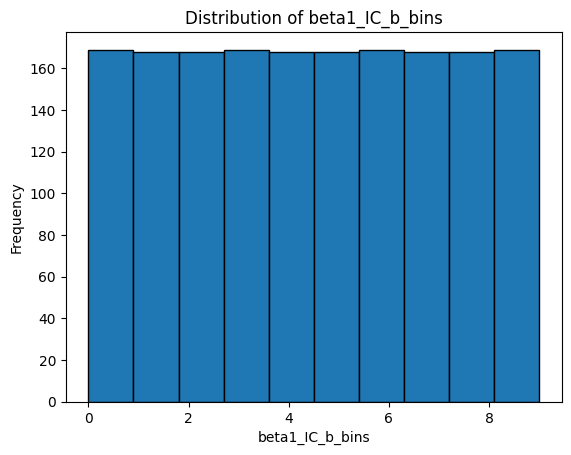

In [ ]:
plt.hist(parameters_selected_df['beta1_IC_b_bins'], bins=10, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('beta1_IC_b_bins')
plt.ylabel('Frequency')
plt.title('Distribution of beta1_IC_b_bins')

Discretise beta1_IC_b based on rotational speed from literature.

Text(0.5, 1.0, 'Distribution of Rotational Speed (Derived from beta1_IC_b)')

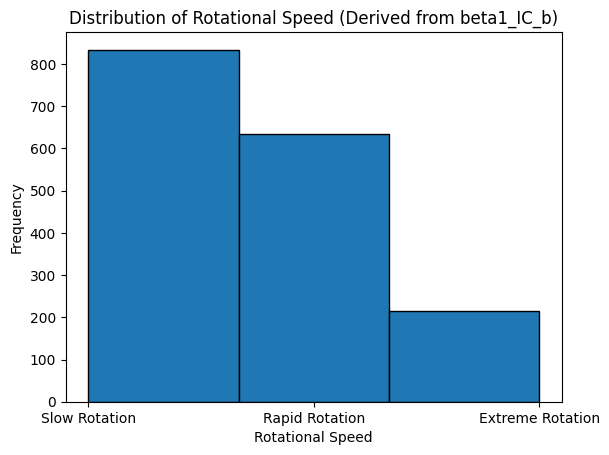

In [ ]:
ranges = [0, 0.06, 0.17, 1]
labels = ["Slow Rotation", "Rapid Rotation", "Extreme Rotation"]

parameters_selected_df['discretized_beta1_IC_b'] = pd.cut(parameters_selected_df['beta1_IC_b'], bins=ranges, labels=labels)

plt.hist(parameters_selected_df['discretized_beta1_IC_b'], bins=3, edgecolor='k')
plt.xlabel('Rotational Speed')
plt.ylabel('Frequency')
plt.title('Distribution of Rotational Speed (Derived from beta1_IC_b)')

### EOS: Equation of State

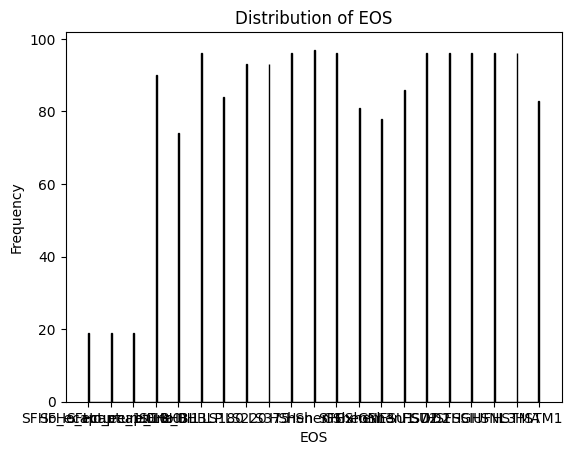

In [ ]:
plt.hist(parameters_selected_df['EOS'], bins=500, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('EOS')
plt.ylabel('Frequency')
plt.title('Distribution of EOS')
plt.show()

Seems roughly uniformly distribution

#### A: differential rotation parameter in Equation 5 (km)

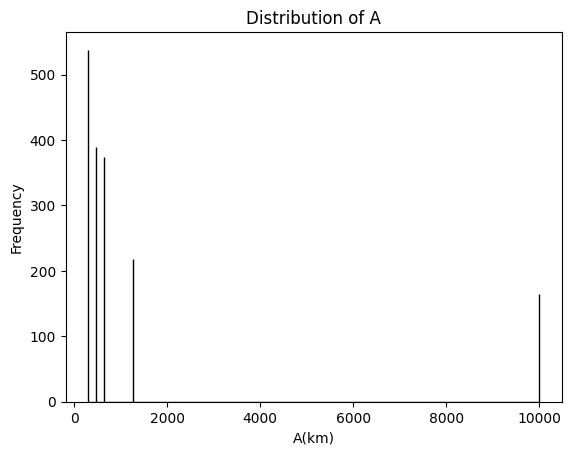

In [ ]:
plt.hist(parameters_selected_df['A'], bins=5000, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('A(km)')
plt.ylabel('Frequency')
plt.title('Distribution of A')
plt.show()

In [ ]:
unique_values = parameters_selected_df['A'].unique()
print(unique_values)

[  634   300   467  1268 10000]


Only 5 unique differential rotation values. There is a noticeable number of supernovae with differential rotation parameter values around 10000 km, quite an outlier from the ones around 500 - 1500 km. Not sure why?

#### omega_0: initial (pre-collapse) rotation rate used in Equation 5 (rad/s)

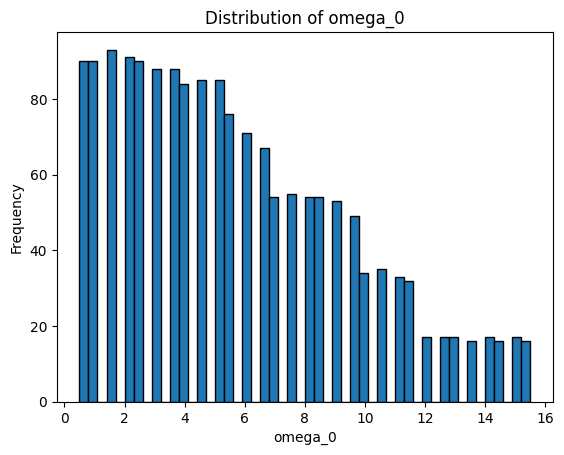

In [ ]:
plt.hist(parameters_selected_df['omega_0'], bins=50, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('omega_0')
plt.ylabel('Frequency')
plt.title('Distribution of omega_0')
plt.show()

### ye: electron dick something

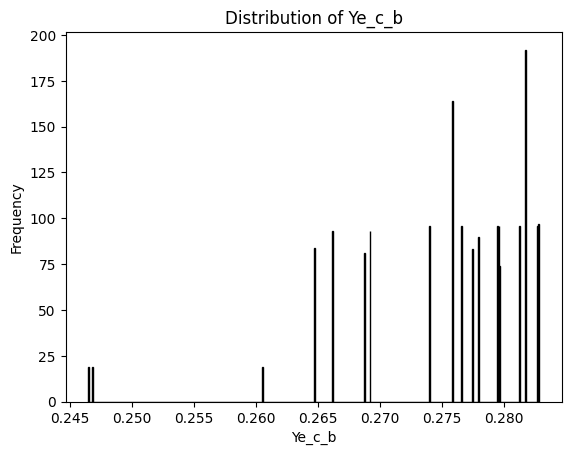

In [ ]:
plt.hist(parameters_selected_df['Ye_c_b'], bins=500, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('Ye_c_b')
plt.ylabel('Frequency')
plt.title('Distribution of Ye_c_b')
plt.show()

/Users/tarineccleston/Documents/software-ds/gw-generative-models/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


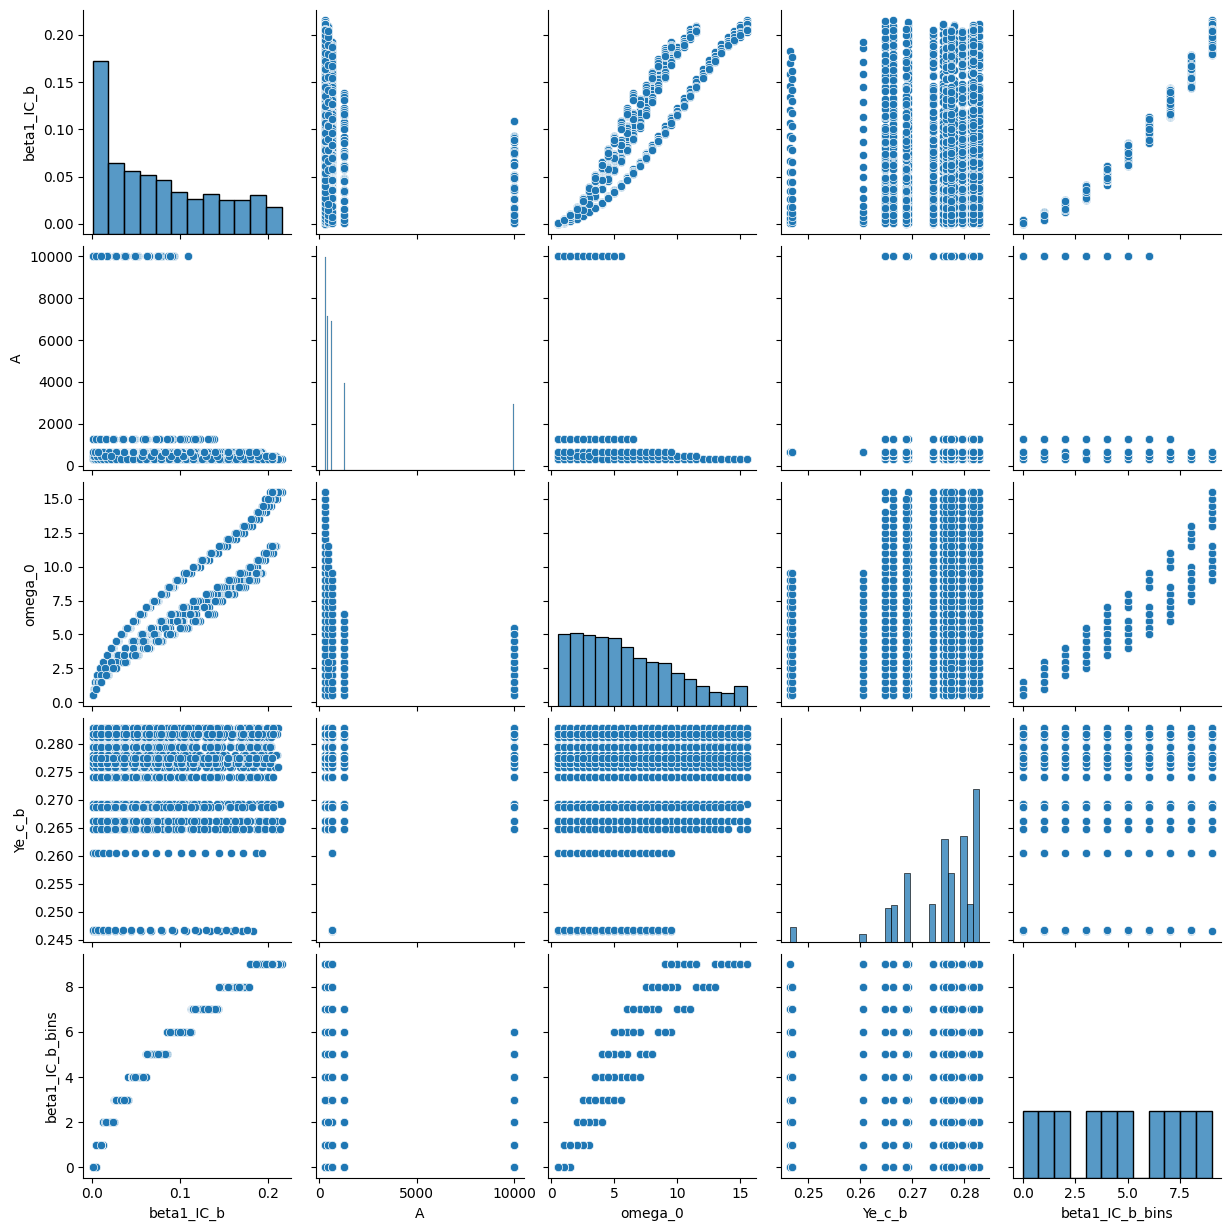

In [ ]:
sns.pairplot(parameters_selected_df)

Nice relationship between omega_0 and beta1_IC_b. Each ____ could be due to using different EOS. Need to confirm this.